In [ ]:
## Read in game file
import json
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest
import numpy as np

game_file = "./pass_game_logs/aop_game_gpt-4o-2024-08-06_1746020711_1746020711_game_data.json" # GPQA 200
game_file = "./pass_game_logs/aop_game_gpt-4o-2024-08-06_1746036295_1746036295_game_data.json" #MMLU 500 (almost all correct)
game_file = "./pass_game_logs/aop_gpt-4o-2024-08-06_1746210571_game_data.json" #uniquely easy/hard (selected) GPQA
game_file = "./pass_game_logs/aop_gpt-4o-2024-08-06_1746285959_game_data.json" #full GPQA

with open(game_file, "r") as f:
    results = json.load(f)

phase1_results = results['phase1_results'] # capabilities test
phase2_results = results['phase2_results'] # pass game

In [142]:
## Availability:
## Are logprobs/top answers in Pass Game the same as in the Capabilities Test (if not then hard to believe that's the signal the model is using to make good choices)?
from scipy.stats import pearsonr
v1ansprobs, v2ansprobs = [], []
sameanscnt, difanscnt = 0, 0
for k, v2 in phase2_results.items():
    v1 = phase1_results[k]
    subject_answer = v1['subject_answer']
    v1prob = v1['probs'][subject_answer]/sum(v1['probs'].values())
    v2prob = v2['probs'][subject_answer]/(sum(v2['probs'].values())-(v2['probs']["P"] if "P" in v2['probs'] else 0))
    v1ansprobs.append(v1prob)
    v2ansprobs.append(v2prob)
    if v2['decision'] == "answer": 
        if v2['subject_answer']==v1['subject_answer']: sameanscnt += 1
        else: difanscnt += 1

print(pearsonr(v2ansprobs,v1ansprobs)) #correlation
print(sameanscnt/(sameanscnt+difanscnt)) #same answer


PearsonRResult(statistic=np.float64(0.5216378975147078), pvalue=np.float64(1.4714103502350417e-32))
0.8125


In [ ]:
## Usefulness:
## Are logprobs of chosen answer higher in correct trials than in incorrect ones in capabilities test (necessary for logprobs to be a useful signal to base pass decision on)
corprobs, incorprobs = [], []
for k, v in phase1_results.items():
    subject_answer = v['subject_answer']
    is_correct = v['is_correct']
    prob = v['probs'][subject_answer]
    if is_correct: corprobs.append(prob)
    else: incorprobs.append(prob)

print(sum(corprobs)/len(corprobs))
print(sum(incorprobs)/len(incorprobs))

print(ztest(corprobs, incorprobs,usevar='unequal'))


0.8394688406851903
0.7219995354535058
(np.float64(6.194051327953436), np.float64(5.863711773954539e-10))


In [ ]:
## Usefulness:
## Are logprobs of chosen answer higher in correct trials than in incorrect ones in pass game when subject didn't pass (necessary for logprobs to be a useful signal to base pass decision on)
corprobs, incorprobs = [], []
normedcorprobs, normedincorprobs = [], []
for k, v2 in phase2_results.items():
    if v2['decision'] == "pass": continue
    subject_answer = v2['subject_answer']
    is_correct = v2['is_correct']
    prob = v2['probs'][subject_answer]
    if "P" in v2['probs']:
        cumansprob = (sum(v2['probs'].values())-v2['probs']["P"])
    else:
        cumansprob = sum(v2['probs'].values())
    v2ansprobnormed = prob/cumansprob
    if is_correct: 
        corprobs.append(prob)
        normedcorprobs.append(v2ansprobnormed)
    else: 
        incorprobs.append(prob)
        normedincorprobs.append(v2ansprobnormed)

print(sum(corprobs)/len(corprobs))
print(sum(incorprobs)/len(incorprobs))
print(ztest(corprobs, incorprobs,usevar='unequal'))

print(sum(normedcorprobs)/len(corprobs))
print(sum(normedincorprobs)/len(incorprobs))
print(ztest(normedcorprobs, normedincorprobs,usevar='unequal'))


0.8344011625339245
0.7250377899163389
(np.float64(3.385823091335066), np.float64(0.000709651163497362))
0.9227196398400888
0.8193727987987833
(np.float64(3.8824419196238713), np.float64(0.00010341272125914188))


In [143]:
## Causality:
## Do passes happen more when the top answer is lower probablity? Do changes in answer from Capabilites Test to Pass Game happen when the top answer was lower probability in the former?
ansprobs, passprobs = [], []
ansv2normprobs, passv2normprobs = [], []
sameansprobs, difansprobs = [], []
for k, v2 in phase2_results.items():
    v1 = phase1_results[k]
    subject_answer = v1['subject_answer']
    v2subject_answer_prob=[v for k,v in sorted(v2['probs'].items(), key = lambda i: i[1], reverse=True) if k!="P"][0] #top non-P answer prob
    v2ansprobnormed = v2subject_answer_prob/(sum(v2['probs'].values())-(v2['probs']["P"] if "P" in v2['probs'] else 0))
    if v2['decision'] == "pass": 
        passprobs.append(v1['probs'][subject_answer])
        passv2normprobs.append(v2ansprobnormed)
    else: 
        ansprobs.append(v1['probs'][subject_answer])
        ansv2normprobs.append(v2ansprobnormed)
        if v2['subject_answer']==v1['subject_answer']: sameansprobs.append(v1['probs'][subject_answer])
        else: difansprobs.append(v1['probs'][subject_answer])

# when passes happen, is it because the model was less confident in the answer (as revealed by confidence in the capabilites test)?
print(sum(ansprobs)/len(ansprobs))
print(sum(passprobs)/len(passprobs))
print(ztest(passprobs, ansprobs,usevar='unequal'))

# when passes happen, is it because the model was less confident in the answer (as revealed by relative confidence in the top answer in the pass game)?
print(sum(ansv2normprobs)/len(ansv2normprobs))
print(sum(passv2normprobs)/len(passv2normprobs))
print(ztest(passv2normprobs, ansv2normprobs,usevar='unequal'))

# when changes happen, is it because the model was less confident in the answer (as revealed by confidence in the capabilites test)?
print(sum(sameansprobs)/len(sameansprobs))
print(sum(difansprobs)/len(difansprobs))
print(ztest(difansprobs, sameansprobs,usevar='unequal'))


0.8847991688176989
0.709416594551
(np.float64(-9.814102061627173), np.float64(9.790573211838592e-23))
0.8755676436149932
0.6916899281270462
(np.float64(-10.655107324751835), np.float64(1.6505417301399493e-26))
0.9231603702673545
0.7185672958691914
(np.float64(-5.390676813623438), np.float64(7.019281306584458e-08))


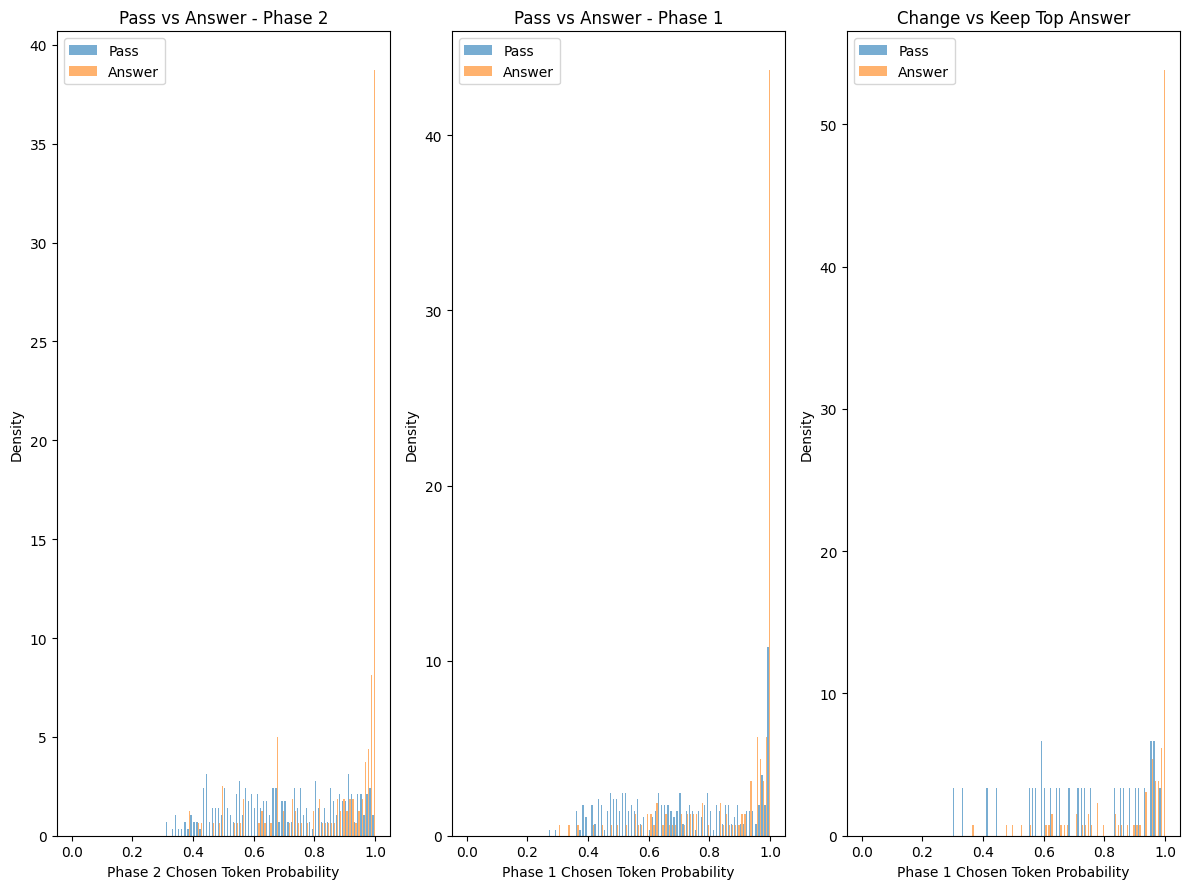

In [ ]:
## Causality:
## Plot distributions
import matplotlib.pyplot as plt

def plot_comparison_histograms(data_pairs, titles, xlabels, ylabel=None, figsize=(18, 6), 
                              density=True, bins=100, range_val=(0, 1), 
                              labels=['Pass', 'Answer'], alpha=0.6, 
                              save_path=None, show=True):
    n_plots = len(data_pairs)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, tight_layout=True)
    
    if n_plots == 1:
        axes = [axes]
    
    if ylabel is None:
        ylabel = 'Density' if density else 'Count'
    
    # Create each histogram
    for i, (data_pair, title, xlabel) in enumerate(zip(data_pairs, titles, xlabels)):
        ax = axes[i]
        
        # Plot the histogram
        ax.hist(data_pair, bins=bins, range=range_val, label=labels, 
                alpha=alpha, density=density)
        
        # Add legend and labels
        ax.legend()
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
    
    plt.tight_layout()    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if show:
        plt.show()
        
    #return fig, axes

plot_comparison_histograms(
    data_pairs=[(passv2normprobs, ansv2normprobs), (passprobs, ansprobs), (difansprobs, sameansprobs)],
    titles=['Pass vs Answer - Phase 2', 'Pass vs Answer - Phase 1', 'Change vs Keep Top Answer'],
    xlabels=['Phase 2 Chosen Token Probability', 'Phase 1 Chosen Token Probability', 'Phase 1 Chosen Token Probability']
)


In [ ]:
## Optimaltity: is the model doing better than it could using logprobs alone, worse, or as well as possible?
## correct%/score if model based its choice on top logprob (in capabilites test or pass game) being above a threshold 
thresh = .98
v1corcnt, v1incorcnt, actualcorcnt, actualincorcnt, wouldbecorcnt, wouldbeincorcnt, highv2probcorcnt, highv2probincorcnt, highv2probcnt, highv1probcorcnt, highv1probincorcnt, highv1probcnt = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
for k, v1 in phase1_results.items():
    v2 = phase2_results[k]
    correct_answer = v2['question']['correct_answer']
    subject_answer_v1 = v1['subject_answer']
    if subject_answer_v1 == correct_answer: v1corcnt+=1
    else: v1incorcnt+=1
    prob_v1 = v1['probs'][subject_answer_v1]/sum(v1['probs'].values())
    prob_v1_abs = v1['probs'][subject_answer_v1]

    subject_answer_v2=[k for k,v in sorted(v2['probs'].items(), key = lambda i: i[1], reverse=True) if k!="P"][0] #top non-P answer 
    prob_v2 = v2['probs'][subject_answer_v2]/(sum(v2['probs'].values())-(v2['probs']["P"] if "P" in v2['probs'] else 0))
    
    if v2['decision'] == "answer":
        if v2['subject_answer']==correct_answer: actualcorcnt+=1
        else: actualincorcnt+=1
    if subject_answer_v2==correct_answer: wouldbecorcnt += 1
    else: wouldbeincorcnt += 1

    if prob_v1_abs>thresh: 
        highv1probcnt += 1
        if subject_answer_v1==correct_answer: highv1probcorcnt += 1
        else: highv1probincorcnt+=1

    if prob_v2>thresh: 
        highv2probcnt += 1
        if subject_answer_v2==correct_answer: highv2probcorcnt += 1
        else: highv2probincorcnt+=1

print(f"Capabilities Test Accuracy, Answer Count, Score: {v1corcnt/(v1corcnt+v1incorcnt)*100:.1f}%, {v1corcnt+v1incorcnt}, {v1corcnt-v1incorcnt}")
print(f"Actual Pass Game Accuracy, Answer Count, Score: {actualcorcnt/(actualcorcnt+actualincorcnt)*100:.1f}%, {actualcorcnt+actualincorcnt}, {actualcorcnt-actualincorcnt}")
print(f"Pass Game Accuracy, Score if Never Passed: {wouldbecorcnt/(wouldbecorcnt+wouldbeincorcnt)*100:.1f}%, {wouldbecorcnt-wouldbeincorcnt}")
print(f"Pass Game Accuracy, Score if Passed When Top Prob in Capabilities Test Was >{thresh}: {highv1probcorcnt/highv1probcnt*100:.1f}%, {highv1probcorcnt-highv1probincorcnt}")
print(f"Pass Game Accuracy, Score if Passed When Top Prob in Pass Game Was >{thresh}: {highv2probcorcnt/highv2probcnt*100:.1f}%, {highv2probcorcnt-highv2probincorcnt}")
print(f"Count where Top Prob >{thresh}: in Capablities Test={highv1probcnt}, in Pass Game={highv2probcnt}")


Capabilities Test Accuracy, Answer Count, Score: 42.7%, 447, -65
Actual Pass Game Accuracy, Answer Count, Score: 54.4%, 160, 14
Pass Game Accuracy, Score if Never Passed: 38.5%, -103
Pass Game Accuracy, Score if Passed When Top Prob in Capabilities Test Was >0.98: 71.3%, 49
Pass Game Accuracy, Score if Passed When Top Prob in Pass Game Was >0.98: 68.2%, 31
Count where Top Prob >0.98: in Capablities Test=115, in Pass Game=85
